In [1]:
import random
from random import randrange

from ase.io import write
from ase.data import atomic_numbers
from ase.ga.data import PrepareDB
from ase.visualize import view

import numpy as np
import os

from pyxtal import pyxtal
from pyxtal.crystal import Lattice
from pyxtal.crystal import random_crystal_2D
from pyxtal.crystal import Tol_matrix

from ase.calculators.siesta import Siesta
from ase.units import Ry

import seaborn as sns
import pandas as pd

## Inputs

In [2]:
name = 'C2'
n_ind = 10                                        #no. of structures in population
a = 0.5                                          #Percentage of individuals
n_gen = 10                                        #Number of generations

In [3]:
n_id = 1

#Creating a file
file_name = f'DateBase_{name}_rulette.txt'

In [4]:
def dist(a, b):  # returns distance of two vectors
    d = np.sqrt((a[0] - b[0]) * (a[0] - b[0]) + (a[1] - b[1]) * (a[1] - b[1]) + (a[2] - b[2]) * (a[2] - b[2]))
    return d

In [5]:
def check_dist(nat, positions, dmin, dmax):
    # checks if atoms' positions fullfill dmin distance constraint, returns flag 1/0
    flag = 1
    for i in range(nat):
        for j in range(nat):
            if i != j:
                ds = dist(positions[i], positions[j])
                if (ds < dmin) or (ds > dmax):
                    flag = 0
    return flag

## Structure Initialization 

In [6]:
def init_atoms():
    atoms_out = None
    Natt = 200 # no of attempts
    for i in range(Natt):
        group_id = randrange(80) + 1
        my_crystal = pyxtal()
        
        try:
            my_crystal.from_random(2, group_id, ['C'], [2], thickness=1.0)
        except RuntimeError:
            continue
        #
        atoms = my_crystal.to_ase()
        positions = atoms.get_positions()
        nat = len(atoms.get_chemical_symbols()) 
        #
        dmin = 1.0
        dmax = 2.5
        flag = check_dist(nat, positions, dmin, dmax)
        
        if flag==1:
            atoms_out = atoms
            break
    return atoms_out  #Atoms object

## Siesta calculator 

In [7]:
calc = Siesta(label=name,       
               xc='PBE',
               mesh_cutoff=200 * Ry,
               energy_shift=0.01 * Ry,
               basis_set='SZP',
               kpts=[12, 12, 1],
               pseudo_path='/home/czeski/Pobrane/siesta-4.1-b4/pseudo',
               fdf_arguments={'MaxSCFIterations': 500,   
                              'DM.Tolerance': 1.E-5,
                              'DM.NumberPulay': 6,                        
                              'DM.NumberBroyden': 0,
                              'DM.MixingWeight': 0.1000000000,             
                              'DM.OccupancyTolerance':0.1000000000E-11,         
                              'DM.NumberKick': 0,                        
                              'DM.KickMixingWeight': 0.5000000000,
                              'MD.NumCGsteps': 50,                        
                              'MD.TypeOfRun': 'CG',                       
                              'MD.VariableCell': 'F',                        
                              'WriteMullikenPop': 1,    
                              'WriteDenchar': True,      
                              'WriteKpoints': True,      
                              'WriteForces': True,      
                              'WriteDM': True,      
                              'WriteXML': True,      
                              'WriteEigenvalues': False, 
                              'WriteCoorStep': True,      
                              'WriteMDhistory': True,    
                              'WriteMDXmol': True,      
                              'WriteCoorXmol': True, 
                             },)

## Indyvidual

In [8]:
class Indyvidual:
    

    
    def __init__(self, structure,n_gen):
        self.calc = calc                    
        self.init_structure = structure     
        self.energy = 0.0
        self.ngen = n_gen
        self.status = 'Random'
        self.id = n_id
        
    def calc_energy(self):
        self.init_structure.calc = calc
        self.energy = self.init_structure.get_potential_energy()
        
    def next_gen(self):
        self.ngen = self.ngen + 1
        
    def mutation(self):
        positions = self.init_structure.get_positions()
        new = [ n + (random.random()-0.5) for n in positions]    
        self.init_structure.set_positions(new)
        self.status = 'Mutated'
    
    def get_init_structure(self):
        return self.init_structure.copy()
    
    def get_energy(self):
        return self.energy
    
    def get_ngen(self):
        return self.ngen
    
    def get_position(self):
        return self.init_structure.get_positions()
    
    def get_status(self):
        return self.status
    
    def get_id(self):
        return self.id    
    

In [9]:
def energy_sorting(pop):
    for i in range(len(pop)):
        pop[i].calc_energy()
    
    sorted_pop = sorted(pop, key=lambda x: x.energy) 

    for i in range(len(sorted_pop)):
        print(sorted_pop[i].get_energy())
    return sorted_pop
    

In [10]:
#Returns 1 if change is less then 2% 
def flag(new, old):                                    
    if ((old- new)/old < 0.02):
        print((old- new)/old < 0.02)
        return 1 
    return 0

### Saving to TextFile

In [11]:
#Input: Population, file, generation number
def write_file(pop,f,g):             
    f.write(f'Generation nr:{g}')
    f.write('\n')
    for i in range(len(pop)):
        f.write(f'Energy: {pop[i].get_energy()}, Status: {pop[i].get_status()}')
        f.write('\n')

## Choice by Rulette 
#### Returns indyvidual nuber 

In [12]:
def choice_by_rulette(pop):
    
    #Totaly population fitness
    population_sum = sum([individual.get_energy() for individual in pop])
    
    #Each individual probability
    individuals_prob = [individual.get_energy()/population_sum for individual in pop]
    
    n = np.arange(0,len(pop))
    while True:
        indyvidual =  np.random.choice(n, p=individuals_prob)
        #The best indyvidual in untouchable
        if (indyvidual==0):
            continue
        return indyvidual




## Starting population

In [13]:
am =int(a*n_ind)                                 #Amount of individuals going to the next generation
arr = np.arange(am,n_ind)                        #Array of iterations
best = []
data = []                                        #Array for data base

f=open(file_name, "w")


#Preapering first population
pop = [] 
i=1
while (len(pop)<n_ind):
    pop.append(Indyvidual(init_atoms(), 1))
    i=i+1

sorted_pop = energy_sorting(pop)
data.append(sorted_pop)                         #Collecting data
write_file(sorted_pop, f, 1)                    #Writing first generation to file
best.append(sorted_pop[0].get_energy())

-305.472388
-304.102926
-302.441874
-301.716453
-301.58915
-300.133765
-298.115646
-297.181592
-295.482031
-250.762645


## Next generations 

## Next Generations but using Choice by Roulette

In [14]:
for g in range(n_gen):
    #a%  of the best individuals go to the next generation
    new_pop = sorted_pop[0:am]                   
    chosen = choice_by_rulette(new_pop)
    new_pop[chosen].mutation()
    new_pop[chosen].calc_energy()
    
    #Appending new random individuals
    i=1
    while (len(new_pop)<(n_ind)):                   
        new_pop.append(Indyvidual(init_atoms(), g+2))
        i=i+1   
    
    #Calculating energy of new individuals
    for i in arr:
        new_pop[i].calc_energy()                 
    
    #Sorting Population
    sorted_pop = sorted(new_pop, key=lambda x: x.energy)
    
    print("\nGeneration nr:",g + 1)
    print("Sorted Energies:")
    
    for i in range(len(sorted_pop)):
        print(sorted_pop[i].get_energy())
    best.append(sorted_pop[0].get_energy())
    
    
    
    data.append(sorted_pop)
    write_file(sorted_pop, f, g+2)  
    write(filename=f"BestStructGen{g+1}rlette{name}.in", images=sorted_pop[0].init_structure, format='espresso-in')
    

f.close()



Generation nr: 1
Sorted Energies:
-305.472388
-304.485885
-304.102926
-303.432479
-303.251193
-302.441874
-301.716453
-300.733608
-300.191237
-255.547374

Generation nr: 2
Sorted Energies:
-305.472388
-304.485885
-304.102926
-303.93616
-303.251193
-300.757672
-300.225523
-296.163015
-295.421886
-280.696161


/home/czeski/anaconda3/lib/python3.8/site-packages/pyxtal/msg.py:21: UserWarning: Error: the stoichiometry is incompatible with wyckoff choice
  warn(text)



Generation nr: 3
Sorted Energies:
-305.472388
-305.082079
-304.642288
-304.485885
-304.203437
-303.93616
-303.251193
-301.893346
-300.725041
-289.854199

Generation nr: 4
Sorted Energies:
-305.472388
-305.082079
-304.642288
-304.485807
-304.203437
-301.775644
-299.725896
-297.917705
-285.442512
-250.080133

Generation nr: 5
Sorted Energies:
-305.472388
-305.333579
-305.082079
-304.642288
-304.485807
-303.448956
-302.235103
-302.101518
-299.094157
-297.622977

Generation nr: 6
Sorted Energies:
-305.834072
-305.472388
-305.333579
-305.082079
-304.650689
-304.485807
-303.843462
-301.735398
-301.538412
-298.307425

Generation nr: 7
Sorted Energies:
-305.834072
-305.472388
-305.333579
-305.082079
-304.648474
-300.81393
-300.145375
-300.102587
-299.932094
-299.475203

Generation nr: 8
Sorted Energies:
-305.834072
-305.472388
-305.333579
-305.081193
-304.648474
-304.610765
-303.090327
-301.640902
-299.566537
-299.248586

Generation nr: 9
Sorted Energies:
-307.123131
-305.834072
-305.472388
-

## View Best Individual

In [15]:
from ase import Atoms
from ase_notebook import AseView, ViewConfig, get_example_atoms

config = ViewConfig()
ase_view = AseView(config)

ase_view = AseView(
    rotations="0x,0y,0z",
    atom_font_size=16,
    axes_length=30,
    canvas_size=(400, 400),
    zoom=1.2,
    show_bonds=True
)
ase_view.config.uc_dash_pattern=(.6,.4)
ase_view.add_miller_plane(
    1, 0, 0, color="green")
ase_view.config



ase_view.config.canvas_color_background = "white"
ase_view.config.canvas_background_opacity = 0
gui = ase_view.make_render(
    sorted_pop[0].get_init_structure() , center_in_uc=True)
gui

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 38.68076602076913), p…

## Creating Database 

In [16]:
ind = []
for i in range(len(data)):
    for j in range(n_ind):
        ind.append(data[i][j])    

In [17]:
d = {'indyvidual': ind}
df=pd.DataFrame(data = d)
df

def get_energyDF(x):
    return x.get_energy()

def get_ngenDF(x):
    return x.get_ngen()

def get_statusDF(x):
    return x.get_status()

def get_idDF(x):
    return f"{name}  {x.get_id()}"

df['id'] = df['indyvidual'].apply(get_idDF)
df['energy'] = df['indyvidual'].apply(get_energyDF)
df['n_gen'] = df['indyvidual'].apply(get_ngenDF)
df['status'] = df['indyvidual'].apply(get_statusDF)

df = df.drop_duplicates(subset=['indyvidual'], keep='last')
df.sort_values('energy')


,indyvidual,id,energy,n_gen,status
100,<__main__.Indyvidual object at 0x7f71e7b57520>,C2 1,-307.123131,10,Random
101,<__main__.Indyvidual object at 0x7f71b5861af0>,C2 1,-305.840443,7,Mutated
102,<__main__.Indyvidual object at 0x7f7218aac8b0>,C2 1,-305.472388,1,Random
103,<__main__.Indyvidual object at 0x7f71b5889c70>,C2 1,-305.333579,6,Random
104,<__main__.Indyvidual object at 0x7f71b5889ee0>,C2 1,-305.081193,4,Mutated
95,<__main__.Indyvidual object at 0x7f71b78d6880>,C2 1,-304.648537,4,Mutated
85,<__main__.Indyvidual object at 0x7f71e7b55d90>,C2 1,-304.610765,9,Random
65,<__main__.Indyvidual object at 0x7f7218aac490>,C2 1,-304.485807,1,Mutated
105,<__main__.Indyvidual object at 0x7f71e7b497c0>,C2 1,-303.977622,11,Random
35,<__main__.Indyvidual object at 0x7f7218aac220>,C2 1,-303.936160,2,Mutated


#### Writting best structure espresso_in file 
#### Writting DataBase to csv

In [18]:
write(filename=f"TheBestStruct_rulatka{name}.in", images=sorted_pop[0].init_structure, format='espresso-in')
df.to_csv(f"DataBase_{name}.csv")

#### Creating best Indyviduals Plot

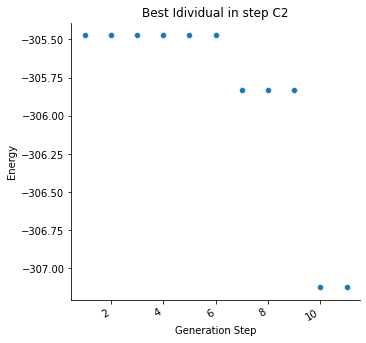

In [19]:
f= sns.relplot(x=np.arange(1, n_gen+2), y=best)
f.set(xlabel='Generation Step', ylabel='Energy', title=f'Best Idividual in step {name}')
sns.axes_style()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
f.fig.autofmt_xdate()